# Analyzing A Movie Review Dataset[100 Points]

## 0. Text Preprocessing [10 Points]

Read through this tutorial on kaggle [here](
https://www.kaggle.com/c/word2vec-nlp-tutorial/details/part-1-for-beginners-bag-of-words) , to
familiarize yourself with its python tools and workflow. You'll have to download "labeledTrainData.tsv" and "testData.tsv" from [here](https://www.kaggle.com/c/word2vec-nlp-tutorial/data). Please remember to add your GT_UserName in the author function below.

In [1]:
def author(gt_username = 'pbutler33'):
    print("This assignment is submitted by {0}.".format(gt_username))

#Add your GT_UserName below and uncomment the line.
#author()


In [2]:
#Import the necessary libraries
import pandas as pd
import numpy as np
import scipy as sp
import re
import nltk
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from copy import deepcopy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import pairwise_distances
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Reading in the data
train = pd.read_csv("labeledTrainData.tsv", delimiter="\t")
test = pd.read_csv("testData.tsv", delimiter="\t")

In [4]:
def preprocess_review(review):
    """Helper function to clean the reviews.

     Arg: review: review text.
     Returns: clean_review : Cleaned reviews

     You should carry out the following steps.
     1. Remove HTML Tags.
     2. Remove non-letter characters.
     3. Convert to lower case.
     4. Remove stopwords.
    """

    #Write your code below.
    cleaned = BeautifulSoup(review).get_text()
    cleaned = re.sub('[^a-zA-Z\' ]', '', cleaned)
    cleaned = cleaned.lower()
    words = cleaned.split()
    stop_words = set(stopwords.words('english'))
    clean_words = [w for w in words if w not in stop_words]
    clean_review = " ".join(clean_words)

    
    

    
    return clean_review


In [5]:
#Clean the reviews and add them to the list below
cleaned_reviews = []

#Write your code below.
for r in train.review:
    cleaned_reviews.append(preprocess_review(r))



## 1. Processing Text to create Design Matrices [15 Points]

In [6]:
def design_matrix(cleaned_reviews):
    """ Generate the 4 design matrices X_counts, X_binary, X_tfidf, X_binary_imbalance.

      Args: cleaned_reviews: Cleaned Reviews.
      Returns:
            X_counts: Design Matrix X_counts.
            X_binary: Design Matrix X_binary(Use the X_counts to generate this.)
            X_tfidf:  Design Matrix X_tfidf
            X_binary_imbalance: Design Matrix X_binary_imbalance(use fraction 0.75)
            imbalance_train: Skewed training set(use fraction 0.75)
    



    """

    #Write your code here.
    vectorizer = CountVectorizer(analyzer = "word",
                                tokenizer = None,
                                preprocessor = None,
                                stop_words = None,
                                max_features = 5000)
    train_features = vectorizer.fit_transform(cleaned_reviews)
    train_features = train_features.toarray()
    X_counts = train_features
    X_binary = X_counts > 0
    X_binary=X_binary.astype('int')
    X_tfidf = TfidfTransformer(smooth_idf = False).fit_transform(X_counts)
    X_tfidf = X_tfidf.toarray()
    np.random.seed(0)
    drop_num = int(sum(train.sentiment) * 0.75)
    idx = train[train.sentiment==1].index
    drop_idx = np.random.choice(idx, drop_num)
    X_binary_imbalance = X_counts.copy()
    X_binary_imbalance = np.delete(X_binary_imbalance, drop_idx, axis=0)
    imbalance_train = train.drop(drop_idx, axis=0)
    
    
    
    
  


    return X_counts,X_binary,X_tfidf,X_binary_imbalance,imbalance_train

In [7]:
X_counts, X_binary, X_tfidf, X_binary_imbalance, imbalance_train = design_matrix(cleaned_reviews)

In [8]:
X_counts

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [9]:
X_binary

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [10]:
X_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
X_binary_imbalance

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

## 2. Feature Space Similarity Experiment [25(5 + 5 + 15) Points]

In [12]:
# Obtain the label on the original train set and imbalance train set
train_sentiment = train["sentiment"].values
imbalance_train_sentiment = imbalance_train["sentiment"].values

In [13]:
def dist(X, i, j, distance_function = "euclidean"):
    """The distance function returns the (Euclidean) distance between rows i and j of a design matrix.
     Args: X : Design Matrix
           i,j: row IDs
           distance_function: The distance function to be used. Here we are using euclidean
     Returns: The distance between row i and row j.
  
    """
    #Write your code here.
    if distance_function == "euclidean":
        distance =  np.linalg.norm(X[i]-X[j])
    else:
        distance = distance_function(X[i], X[j])
    

    return distance

In [14]:
def topk(X, k):
    """The topk(X, k) function returns ((i1,j1,d1),...(ik,jk,dk)) where (ix,jx) are the indices of the xth 
     closest pair, and dx is the corresponding distance. You can break ties randomly.
     Args: X : Design Matrix
           k:  Top k
     Returns: top: A list of [row,col,distance]
  
    """
   
    #Write your code here.
    d_matrix = np.tril(pairwise_distances(X)) #lower triangular dist matrix
    M = np.max(d_matrix)
    d_matrix[d_matrix <= 0] = M #sets 0s to max so they dont interfere with finding closest pairs
    low_idx = np.unravel_index(np.argpartition(d_matrix, axis=None, kth=k), d_matrix.shape)
    top = tuple([(low_idx[0][i], low_idx[1][i], d_matrix[low_idx[0][i], low_idx[1][i]]) for i in range(k)])
        
    
    
    
            
      
    
    
    return top

Use topk() to find the closest review pairs for each design matrix and print the following: the indices of the reviews, the distance, the first 20 characters of each review, the labels for each review.

In [15]:
# compute top k for X_counts matrix and print the following: the indices of the reviews, the distance, the first 20 characters of each review, the labels for each review.
#Write your code here.
top_X_counts = topk(X_counts, 2)
for i in range(2):
    print('pair', i)
    print(train.review[top_X_counts[i][0]][:20])
    print(train.review[top_X_counts[i][1]][:20])

pair 0
Saw this in the thea
Saw this in the thea
pair 1
Having the opportuni
Having the opportuni


In [16]:
# compute top k for X_binary matrix and print the following: the indices of the reviews, the distance, the first 20 characters of each review, the labels for each review.
#Write your code here.
top_X_bin = topk(X_binary, 2)
for i in range(2):
    print('pair', i)
    print(train.review[top_X_bin[i][0]][:20])
    print(train.review[top_X_bin[i][1]][:20])


pair 0
Saw this in the thea
Saw this in the thea
pair 1
Having the opportuni
Having the opportuni


In [17]:
# compute top k for X_tfidf matrix and print the following: the indices of the reviews, the distance, the first 20 characters of each review, the labels for each review.
#Write your code here.
top_X_tfidf = topk(X_tfidf, 2)
for i in range(2):
    print('pair', i)
    print(train.review[top_X_tfidf[i][0]][:20])
    print(train.review[top_X_tfidf[i][1]][:20])

pair 0
Saw this in the thea
Saw this in the thea
pair 1
Having the opportuni
Having the opportuni


In [18]:
# compute top k for X_binary_imbalance matrix and print the following: the indices of the reviews, the distance, the first 20 characters of each review, the labels for each review.
#Write your code here.
top_X_imb = topk(X_binary_imbalance, 2)
for i in range(2):
    print('pair', i)
    print(train.review[top_X_imb[i][0]][:20])
    print(train.review[top_X_imb[i][1]][:20])

pair 0
Saw this in the thea
Saw this in the thea
pair 1
Having the opportuni
Having the opportuni


Are the pairs always the same?

## 3. Classification Experiment [35 Points]

Now you’re going to tune an SVM classifier using each design matrix, and measure the
resultant performance. Read the sklearn [docs](http://scikit-learn.org/stable/modules/cross_validation.html) on cross-validation to see the
methods to use.
*   Set your rng seed to 0 and create an initial learning_set / test_set split of 80-20.
*   Now we want to use a linear SVM (svm.SVC with kernel=linear) and pick the best C value for our classifier.
*   Repeat for each of the four design matrices:
  *  Repeat 30 times:
    *  Pick a random value of C uniformly in the interval (1e-4, 1e4).
    *  Use 5-fold cross-validation to train the SVM.
    *  Estimate and record the F1-Score.
  *  Select the value of C which produced the best F1-Score and find out the F1-Score on the test set using that C.
  *  Retrain the classifier using the entire learning set with this C value.
  *  Submit test set predictions to Kaggle (see the section in the blog, and
make sure you use their test data. You may need to retrain one more
time using all “training data”). Print your Kaggle score.

In [19]:
import matplotlib.pyplot as plt
import random as rd

from sklearn import svm
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score

### 3.1 Utility Functions [10 (5 + 5) Points]

In [20]:
def calculateF1(X, y, k = 5):
    """calculateF1(X, y, k = 5) return two list which record all randomly selected c(in the interval (1e-4, 1e4))
     and corresponding F1 scores.

     Args: X: Features
           y: Label of sentiment
           k: Number of Cross-validation

     Returns: c_list: List of all c values.
              f1_list: Corresponding F1 Scores.
    """
    rd.seed(0) #Setting a common seed

    #Write your code here.
    c_list = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0, 10000]
    #c_list = rd.uniform(0.0001, 10000, 30)
    f1_list = []
    for c in c_list:
        mod = svm.LinearSVC(C = c)
        f_scores = cross_val_score(mod, X, y, cv=k, scoring='f1')
        f1_list.append(sum(f_scores)/5)
        
        
    #I used the c-list above because it makes more sense to use evenly spaced values on a roughly logarithmic scale
    #to hypertune the C parameter. If you want to run this code with the original instruction of sampling C values
    #uniformly from the interval (0.0001, 10000), uncomment the code below the c_list definition and run that instead.
    
        
    return c_list, f1_list

In [21]:
def findBestC(X, y, k = 5):
    """findBestC(X, y, k) return the best performance c, and the improvement(difference between best and worst f1_scores)/
     Args: X: Features
           y: Label of sentiment
           k: Number of Cross-validation
     Returns: c_best: C value with best f1_score.
              improvement: difference between best and worst f1_score.
    """
    #Write your code here.
    c_vals, f_vals = calculateF1(X, y, k)
    c_best = c_vals[np.argmax(f_vals)]
    improvement = np.max(f_vals) - np.min(f_vals)
    
    return c_best,improvement

### 3.2 Tune an SVM classifier using X_counts [20 (4*5) Points]

#### 3.2.0 Utility Function

In [22]:
def findImprovement(X,train_sentiment,test_size = 0.2, random_state = 0):
    """ Find the improvement in F1-Score of the design Matrix(X) using previous utility functions and the test_f1_score using the best C.

      Args: X: Design Matrix
            train_sentiment: Sentiments of the training data
            test_size: Split it as 80:20
            random_state: Seed

      Returns:
            c_best: The best possible c value
            improvement: improvement in F1-Score using the design Matrix(X).
            f1_s: Test F1 Score.
            

      You should carry out the following Steps:
      1. Split the data using the above parameters.
      2. Find out the best c and the improvement. (use 5-fold Cross Validation.)
      3. Find out the test f1 score with this c.
    """
    #Write your code here.
    #Since we have a test set, I do not bother splitting X into train and test, instead I use the test data set
    X_train, X_test, y_train, y_test = train_test_split(X, train_sentiment, test_size = test_size, random_state = random_state)
    c_best, improvement = findBestC(X_train, y_train)
    final_mod = svm.LinearSVC(C=c_best).fit(X_train, y_train)
    preds = final_mod.predict(X_test)
    f1_s = f1_score(preds, y_test)

    return c_best,improvement,f1_s

#### 3.2.1 Tune an SVM classifier using X_counts



In [23]:
#Print the improvement using X_counts and the test f1_score using the best c.
#Write your code here.
c_best_counts, improvement_counts, f1_s_counts = findImprovement(X_counts, train.sentiment)
print(improvement_counts, f1_s_counts)

0.05650875590079851 0.878185831828216


In [24]:
# Retrain the classifier using the entire learning set with c_best
#Write your code here.
counts_mod = svm.LinearSVC(C=c_best_counts).fit(X_counts, train.sentiment)

Submit test set predictions to Kaggle (see the section in the blog, and
make sure you use their test data. You may need to retrain one more
time using all “training data”). Print your Kaggle scores.

In [25]:
#You should do the following steps.
#1. Create bag of words from the test data.
#2. Generate the labels using that test data.
#3. Save the results to the pandas dataframe. For format check the blog.
#4. Submit the results to Kaggle and add the scores here.

#Write your code here.

#Uncomment the below lines and add your score.
test_reviews = []

for r in test.review:
    test_reviews.append(preprocess_review(r))
    
X_counts_test, X_binary_test, X_tfidf_test, X_binary_imbalance_test, imbalance_test = design_matrix(test_reviews)

X_counts_preds = pd.DataFrame(columns = ['id', 'sentiment'])
X_counts_preds.id = test.id
X_counts_preds.sentiment = counts_mod.predict(X_counts_test)
X_counts_preds.to_csv("X_counts_predictions", index=False)
X_counts_result = 0.55523
print("The Kaggle Score using X_counts is {}".format(X_counts_result))

The Kaggle Score using X_counts is 0.55523


#### 3.2.2 Tune an SVM classifier using X_binary

In [26]:
#Print the improvement using X_binary and the test f1_score using the best c.
#Write your code here.
c_best_binary, improvement_binary, f1_s_binary = findImprovement(X_binary, train.sentiment)
print(improvement_binary, f1_s_binary)

0.056058941115158745 0.8702136235388956


In [27]:
# Retrain the classifier using the entire learning set with c_best
#Write your code here.
binary_mod = svm.LinearSVC(C=c_best_binary).fit(X_binary, train.sentiment)

In [28]:
#Use the the same steps as you did for X_counts and print the kaggle score. Please note that you need to find X_binary_test using the X_counts_test.
#Write your code here.
X_binary_preds = pd.DataFrame(columns = ['id', 'sentiment'])
X_binary_preds.id = test.id
X_binary_preds.sentiment = binary_mod.predict(X_binary_test)
X_binary_preds.to_csv("X_binary_predictions", index=False)
X_binary_result = 0.55652
print("The Kaggle Score using X_binary is {}".format(X_binary_result))

The Kaggle Score using X_binary is 0.54864


#### 3.2.3 Tune an SVM classifier using X_tf_idf

In [29]:
#Print the improvement using X_tf_idf and the test f1_score using the best c.
#Write your code here.
c_best_tfidf, improvement_tfidf, f1_s_tfidf = findImprovement(X_tfidf, train.sentiment)
print(improvement_tfidf, f1_s_tfidf)

0.07902993915283363 0.8866599799398196


In [30]:
# Retrain svm using all X_tfidf data
#Write your code here.
tfidf_mod = svm.LinearSVC(C=c_best_tfidf).fit(X_tfidf, train.sentiment)

In [31]:
#Use the the same steps as you did for X_counts and print the kaggle score. Please note that you need to find X_tfidf_test using the X_counts_test.

#Write your code here.

X_tfidf_preds = pd.DataFrame(columns = ['id', 'sentiment'])
X_tfidf_preds.id = test.id
X_tfidf_preds.sentiment = counts_mod.predict(X_tfidf_test)
X_tfidf_preds.to_csv("X_tfidf_predictions", index=False)
X_tfidf_result = 0.54432
print("The Kaggle Score using X_tfidf is {}".format(X_tfidf_result))

The Kaggle Score using X_tfidf is 0.54864


#### 3.2.4 Tune an SVM classifier using X_binary_imbalance

In [32]:
#Print the improvement using X_binary_imbalance and the test f1_score using the best c.
#Write your code here.
c_best_imbalance, improvement_imbalance, f1_s_imbalance = findImprovement(X_binary_imbalance, imbalance_train.sentiment)
print(improvement_imbalance, f1_s_imbalance)

0.1915427513199064 0.7862242755144897


In [33]:
# Retrain svm using all X_binary_imbalance data.
#Write your code here.
imbalance_mod = svm.LinearSVC(C=c_best_imbalance).fit(X_binary_imbalance, imbalance_train.sentiment)

In [34]:
#Use the the same steps as you did for X_counts and print the kaggle score.

#Write your code here.

X_imbalance_preds = pd.DataFrame(columns = ['id', 'sentiment'])
X_imbalance_preds.id = test.id
X_imbalance_preds.sentiment = imbalance_mod.predict(X_counts_test)
X_imbalance_preds.to_csv("X_imbalance_predictions", index=False)
X_imbalance_result = 0.55300
print("The Kaggle Score using X_binary_imbalance is {}".format(X_imbalance_result))

The Kaggle Score using X_binary_imbalance is 0.55523


Which design matrix performed best (e.g., which encoding method worked best)?
What was the lift (improvement in F1-Score) between the worst and best cases for each experiment?

##4. Learning Curve Experiment [15(10 + 5) Points]

Using a logistic regression classifier and the design matrix X_counts, generate a learning curve:
*  Set your rng seed to 0 and create an initial learning_set / test_set split of 80-20.
*  Generate a learning curve (xval vs training error) for n=(100, 500, 1000, 2000,3000, 4000, 5000, 7500, 10000, 15000, 20000) training instances.
*  Interpret the learning curve.

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve

Text(0, 0.5, 'Accuracy')

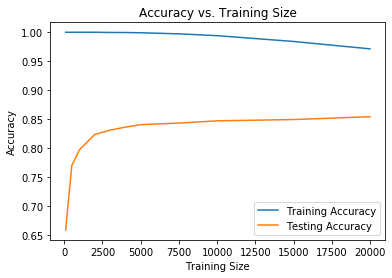

In [36]:
training_instances = [100, 500, 1000, 2000, 3000, 4000, 5000, 7500, 10000, 15000, 20000]
#Use the learning_curve module to generate mean train and test scores and plot them with X-axis being the number of training instances and Y-axis.
#Please add appropriate title,labels and legends.
#Write your code here.
rd.seed(0)
train_sizes, train_scores, test_scores = learning_curve(LogisticRegression(), X=X_counts, y=train.sentiment, train_sizes = training_instances, cv=5)
train_avg = np.mean(train_scores, axis=1) #take row averages of train scores
test_avg = np.mean(test_scores, axis=1) #take row averages of test scores
plt.plot(train_sizes, train_avg, label='Training Accuracy')
plt.plot(train_sizes, test_avg, label='Testing Accuracy')
plt.legend()
plt.title('Accuracy vs. Training Size')
plt.xlabel('Training Size')
plt.ylabel('Accuracy')

##### Please provide an explanation to the nature of your graph in the above experiment.